In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from datetime import timedelta
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression, RANSACRegressor
from sklearn.svm import SVR

plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':100})


C:\Users\dagbo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
start_time = time()

energy_meters_df = pd.read_excel('data/VIS Målere.xlsx')
# Remove leading and trailing whitespace in cells with value of type string
energy_meters_df = energy_meters_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# parse_dates=['Unnamed: 0']

raw_esave_tables_dict = pd.read_excel('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls', decimal=',', sheet_name=None)
raw_esave_tables_list = raw_esave_tables_dict.values()
for table in raw_esave_tables_list:
    table.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
    table['datetime'] = pd.to_datetime(table['datetime'], dayfirst=True)
    table.set_index('datetime', inplace=True)
    table.sort_index()
raw_esave_table = pd.concat(raw_esave_tables_list, axis=1, ignore_index=False)

stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to read xls files')

Used 85.96 seconds to read xls files


In [3]:
start_time = time()

buildings = {}
current_building = None
sensor_types = ['Fastkraft', 'Fjernvarme', 'Varme', 'Elkjel', 'Kjøling']
for _, row in energy_meters_df.iterrows():
    # if current row is a building not a sensor create a new dict to store all sensors for that building
    if row['Objekt'] == 'Bygg':
        current_building = {}
        for sensor_type in sensor_types:
            current_building[sensor_type] = {}
        buildings[row['Navn']] = current_building
        continue
    
    sensor_type = row['Type']
    if sensor_type in sensor_types:
        name = row['Navn']
        sensor_id = row['Formel']
        current_building[sensor_type][name] = sensor_id


stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to parse')

Used 0.05 seconds to parse


In [4]:
# Create a dictionary that contains a dataframe for each building that have column for each sensor type (e.g. Fjernvarme or Fastkraft)
building_dfs = {}
for building_name, sensor_type_dict in buildings.items():

    sensor_type_series = {}
    for sensor_type, sensor_dict in sensor_type_dict.items():
        for sensor_id in sensor_dict.values():
            if sensor_id in raw_esave_table.columns:
                sensor_series = raw_esave_table[sensor_id]
                if not sensor_type in sensor_type_series:
                    sensor_type_series[sensor_type] = sensor_series
                else:
                    sensor_type_series[sensor_type] = sensor_type_series[sensor_type] + sensor_series
    if sensor_type_series:
        df = pd.DataFrame(sensor_type_series)
        df.sort_index(inplace=True)
        df.dropna(axis='index')
        building_dfs[building_name] = df

# Create a column in each building dataframe that is the total energy consumption, i.e. the sum of all other columns.
for building_df in building_dfs.values():
    building_df['Totalt'] = building_df[list(building_df.columns)].sum(axis=1)


In [5]:
# Create new data frames for each building that have values for each day or week instead of hourly
building_daily_dfs = {}
building_weekly_dfs = {}
for building_name, building_df in building_dfs.items():
    building_daily_dfs[building_name] = building_df.resample('D').sum()
    building_weekly_dfs[building_name] = building_df.resample('W-MON').sum()


In [6]:
for building_name, weekly_consumption_dict in building_weekly_dfs.items():
    if weekly_consumption_dict['Totalt'].isnull().values.any():
        print(f'{building_name} have null values')

    if weekly_consumption_dict['Totalt'].isna().values.any():
        print(f'{building_name} have nan values')

In [7]:
temp_voll = raw_esave_table['Eklima_68860_TAM']
temp_voll_weekly_mean = temp_voll.resample('W-MON').mean()
temp_voll_daily_mean = temp_voll.resample('D').mean()

In [8]:
def generate_et_curve1(energy_consumption_series: pd.Series, temperature_series: pd.Series):
    # print(energy_consumption_series)
    # print(temperature_series)
    # energy_consumption_series = energy_consumption_series[energy_consumption_series.isin(temperature_series)]
    # temperature_series = temperature_series[temperature_series.isin(energy_consumption_series)]

    # ensure that we match values for energy and temp, and that there are no nan values.
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    X = df['temperature'].values.reshape(df.shape[0], 1)
    y = df['energy'].values.reshape(df.shape[0], 1)

    # linear regression
    # model = LinearRegression()
    # model.fit(X, y)

    # plt.scatter(X, y,  color='black')
    # plt.plot(X, model.predict(X), color='blue', linewidth=3)
    # plt.show()

    # logistic regression
    # model_log = LogisticRegression()
    # model_log.fit(X, y)
    # plt.scatter(X, y,  color='black')
    # plt.plot(X, model_log.predict(X), color='blue', linewidth=3)
    # plt.show()

    model = SVR(kernel='rbf', C=5000)
    # model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X, y)

    plt.scatter(X, y,  color='black')
    plt.plot(X, model.predict(X), color='blue', linewidth=3)
    plt.show()


    return model


In [9]:
def linear_interpolation(x, x0, y0, x1, y1):
    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class et_curve():
    def __init__(self, dx, dy):
        self.dx = dx
        self.dy = dy

    def expected(self, temperature):
        if temperature < self.dx[0]:
            # print(f'{temperature} is below range, lowest point is ({self.dx[0]}, {self.dy[0]})')
            # TODO improve this prediction
            return linear_interpolation(temperature, self.dx[0], self.dy[0], self.dx[1], self.dy[1])
        if temperature > self.dx[-1]:
            # print(f'{temperature} is above range, highest point is ({self.dx[-1]}, {self.dy[-1]})')
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])
    
    def get_expected_series(self, temperature_series):
        return temperature_series.apply(self.expected)
    
    def get_proportial_series(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return energy_series / expected_series

    def get_anomolies_series(self, energy_series, temperature_series, threshold):
        expected_series = self.get_expected_series(temperature_series)
        mask = energy_series / expected_series >= (threshold + 1)
        return energy_series[mask]

In [10]:
def generate_et_curve2(energy_consumption_series: pd.Series, temperature_series: pd.Series, points_per_segment, plot: bool = False):

    # ensure that we match values for energy and temp, and that there are no nan values.
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    number_of_points = df.shape[0]

    X = df['temperature'].values.reshape(number_of_points, 1)
    y = df['energy'].values.reshape(number_of_points, 1)

    dx = []
    dy = []

    for i in range(0, number_of_points + 1, points_per_segment):
        n = min(points_per_segment, number_of_points - i)

        X_seg = X[i:i+n, :]
        y_seg = y[i:i+n, :]

        model = LinearRegression()
        model.fit(X_seg, y_seg)

        if i == 0:
            X_first = X_seg[0].reshape(1,1)
            y_first = model.predict(X_first)
            dx.append(X_first[0,0])
            dy.append(y_first[0,0])

        X_middle = X_seg[n//2].reshape(1,1)
        y_middle = model.predict(X_middle)
        dx.append(X_middle[0,0])
        dy.append(y_middle[0,0])

        if i >= number_of_points - points_per_segment:
            X_last = X_seg[-1].reshape(1,1)
            y_last = model.predict(X_last)
            dx.append(X_last[0,0])
            dy.append(y_last[0,0])

    if plot:
        plt.plot(dx, dy, color='red', linewidth=3)
        plt.scatter(X, y)
        plt.show()

    return et_curve(dx, dy)


In [11]:
def generate_et_curve3(energy_consumption_series: pd.Series, temperature_series: pd.Series, points_per_segment, plot: bool = False):

    # ensure that we match values for energy and temp, and that there are no nan values.
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    number_of_points = df.shape[0]

    X = df['temperature'].values.reshape(number_of_points, 1)
    y = df['energy'].values.reshape(number_of_points, 1)

    dx = []
    dy = []

    for i in range(0, number_of_points + 1, points_per_segment):
        n = min(points_per_segment, number_of_points - i)

        X_seg = X[i:i+n, :]
        y_seg = y[i:i+n, :]

        model = RANSACRegressor()
        try:
            model.fit(X_seg, y_seg)
        except:
            # TODO: if we end up using RANSACRegressor we must add some error handling that uses more points for segment if it fails to fit for number of points initially given
            continue

        if i == 0:
            X_first = X_seg[0].reshape(1,1)
            y_first = model.predict(X_first)
            dx.append(X_first[0,0])
            dy.append(y_first[0,0])

        X_middle = X_seg[n//2].reshape(1,1)
        y_middle = model.predict(X_middle)
        dx.append(X_middle[0,0])
        dy.append(y_middle[0,0])

        if i >= number_of_points - points_per_segment:
            X_last = X_seg[-1].reshape(1,1)
            y_last = model.predict(X_last)
            dx.append(X_last[0,0])
            dy.append(y_last[0,0])

    if plot:
        plt.plot(dx, dy, color='red', linewidth=3)
        plt.scatter(X, y)
        plt.show()

    return et_curve(dx, dy)


In [12]:
test_building_name = 'Trondheim Kommune - Lilleby skole'

et_reg = generate_et_curve3(building_weekly_dfs[test_building_name]['Totalt'], temp_voll_weekly_mean, 40)

et_reg

Trondheim Kommune - General Wibes veg 1


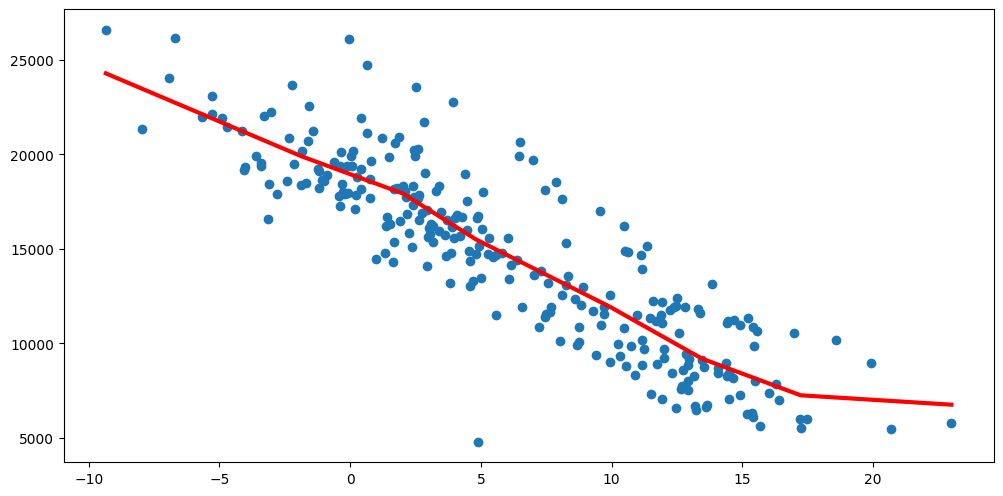

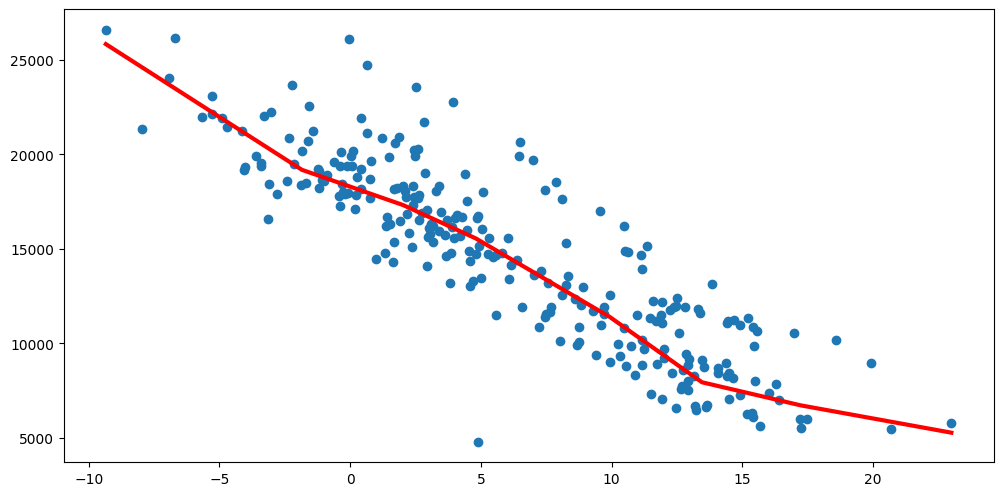

Trondheim Kommune - Spongdal skole og Byneshallen


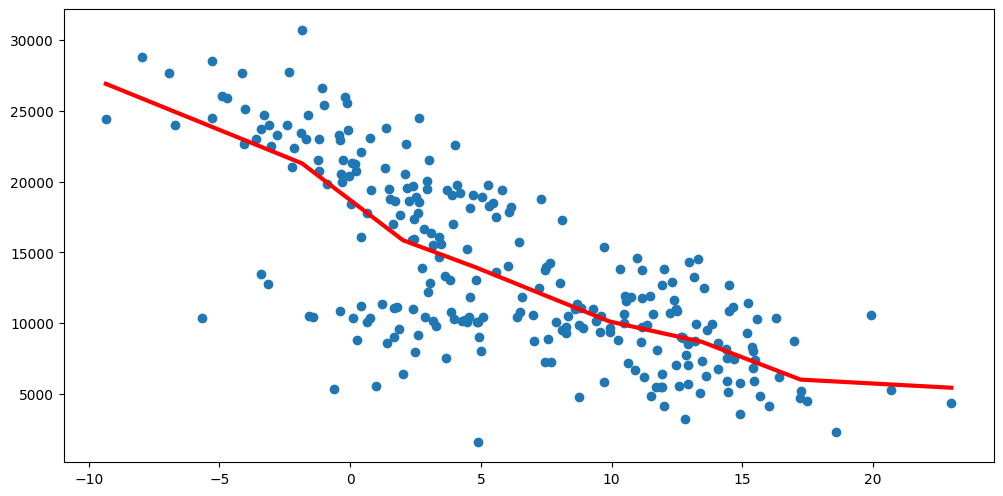

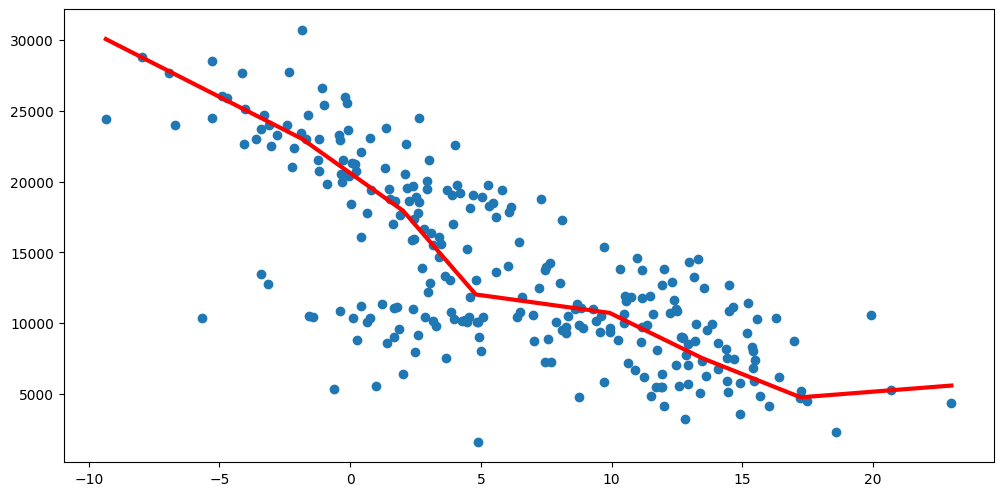

Trondheim Kommune - Ladesletta helse- og velferdssenter


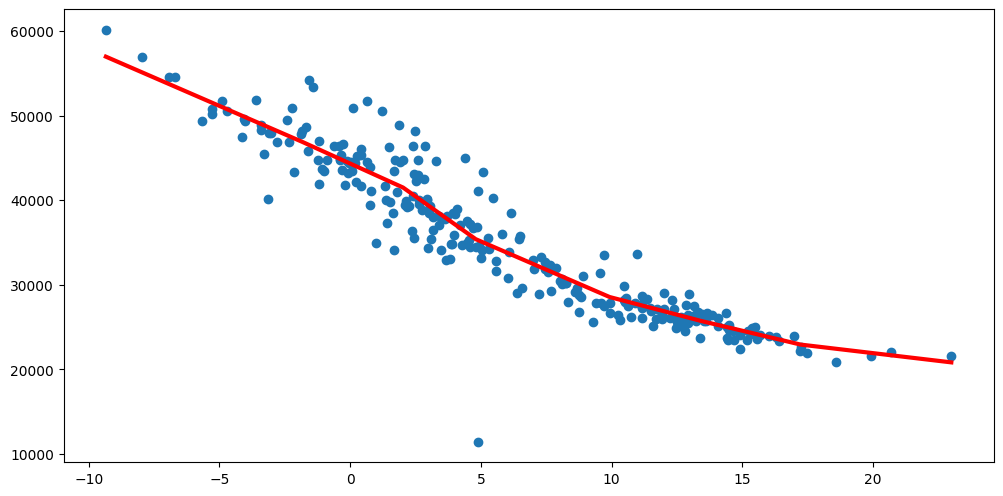

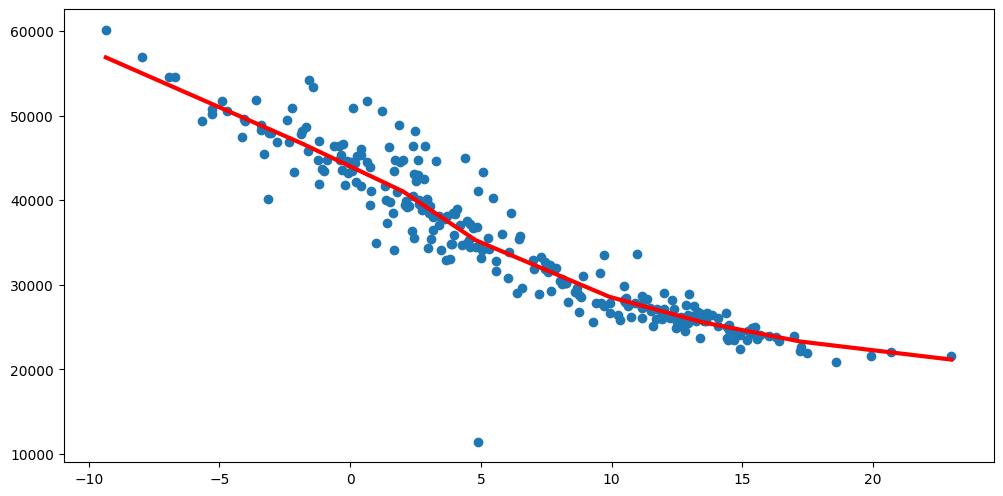

In [13]:
i = 0

et_curves_dict = {}
for name, weekly_consumption in building_weekly_dfs.items():
    i += 1

    num_to_plot = 4
    if i < num_to_plot:
        print(name)

    building_et_curve1 = generate_et_curve2(weekly_consumption['Totalt'], temp_voll_weekly_mean, 50, i < num_to_plot)
    building_et_curve2 = generate_et_curve3(weekly_consumption['Totalt'], temp_voll_weekly_mean, 50, i < num_to_plot)
    et_curves_dict[building_name] = building_et_curve1

In [14]:
building_day_of_week_dfs = {}
for building_name in building_dfs.keys():
    day_of_week_dict = {}
    building_day_of_week_dfs[building_name] = day_of_week_dict
    for i in range(7):
        day_of_week_dict[i] = building_daily_dfs[building_name].iloc[building_daily_dfs[building_name].index.dayofweek == i]


Trondheim Kommune - General Wibes veg 1
Monday


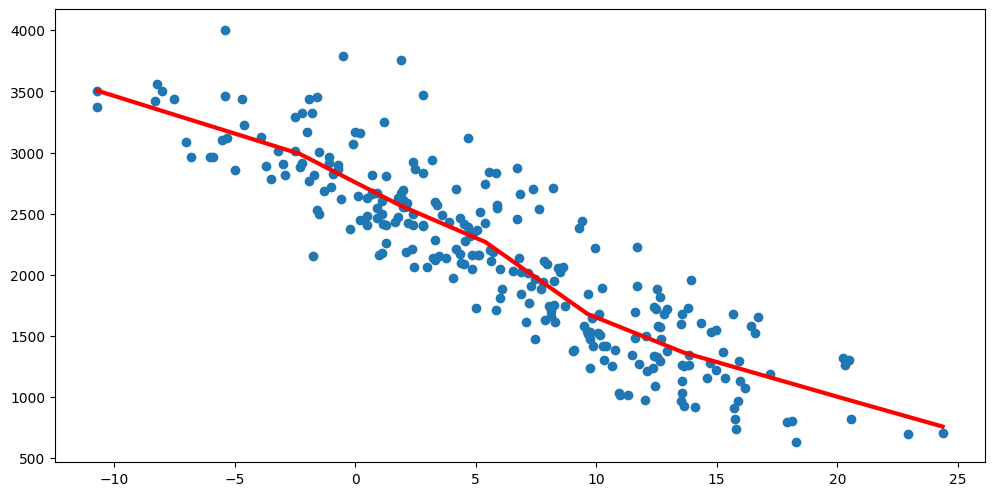

Tuesday


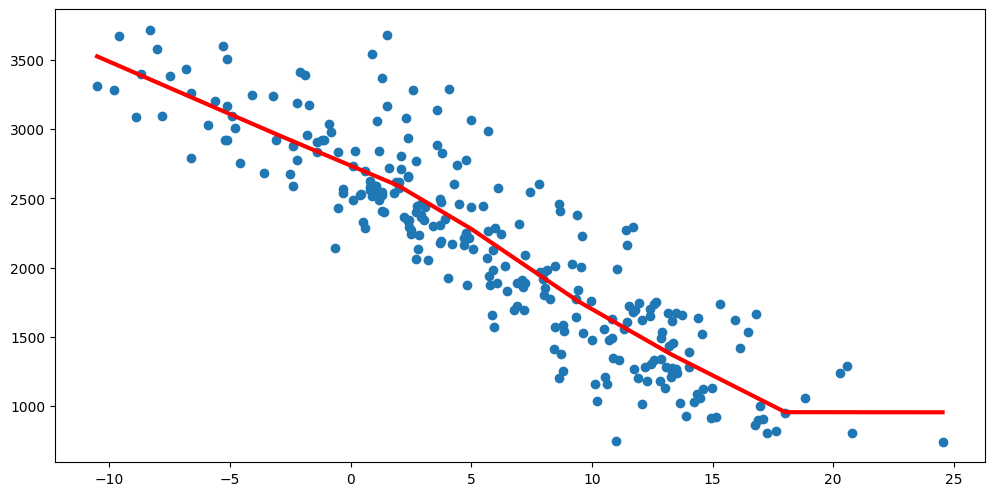

Wednesday


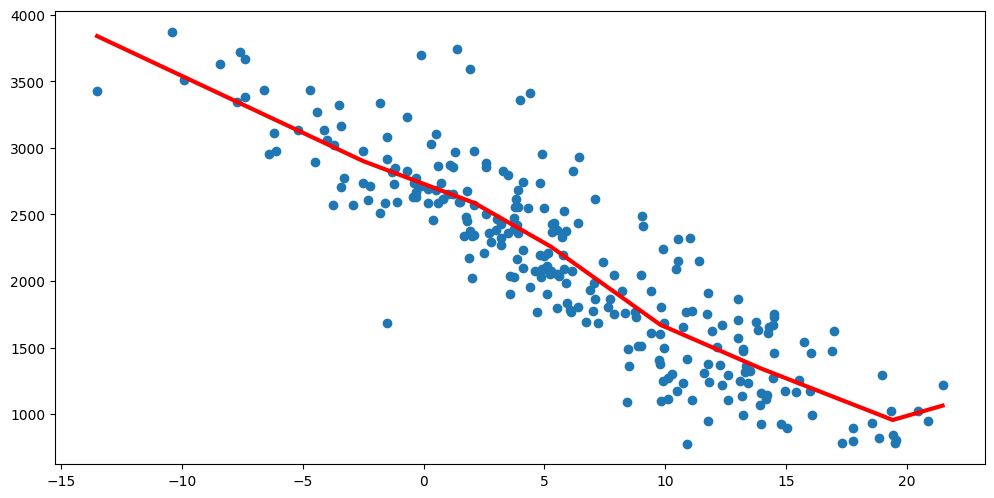

Thursday


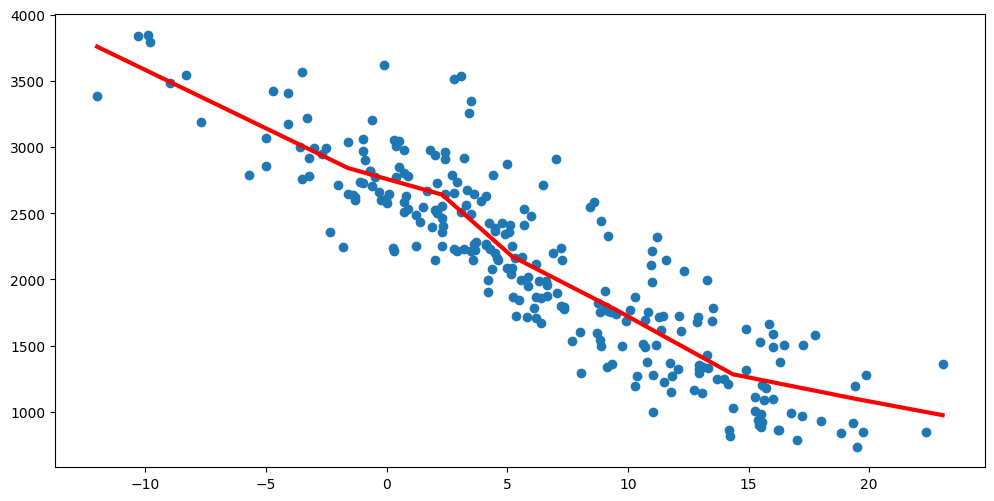

Friday


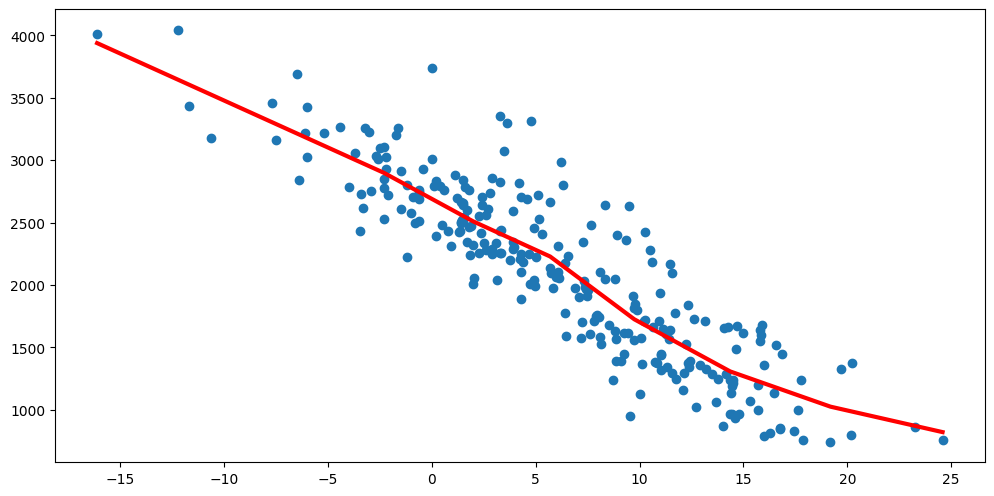

Saturday


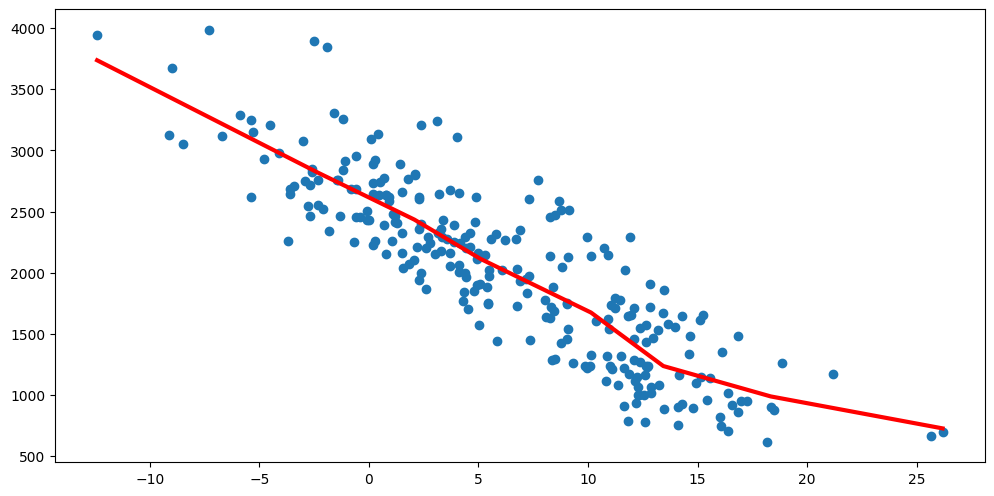

Sunday


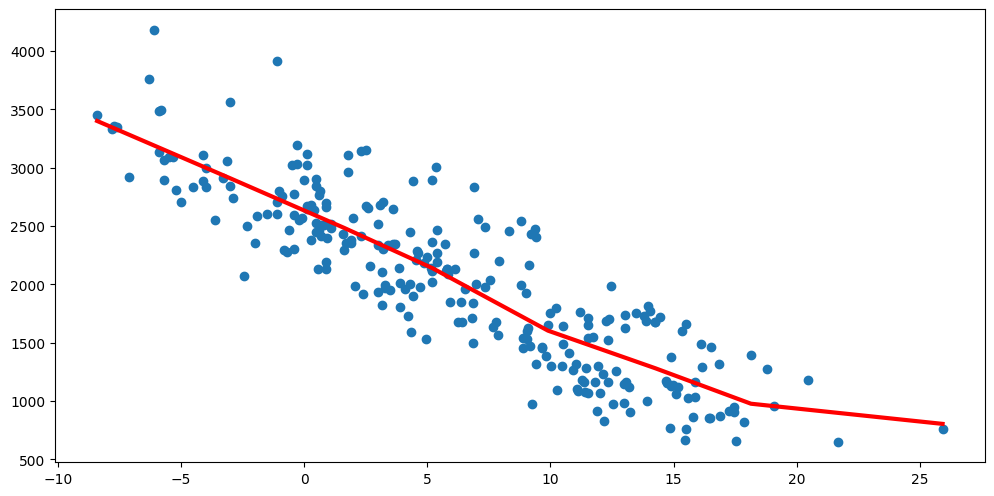

Trondheim Kommune - Spongdal skole og Byneshallen
Monday


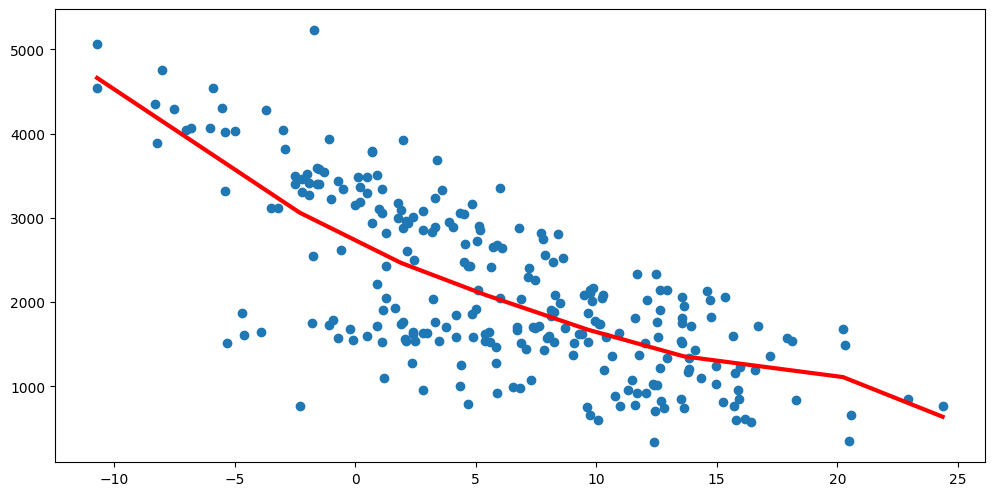

Tuesday


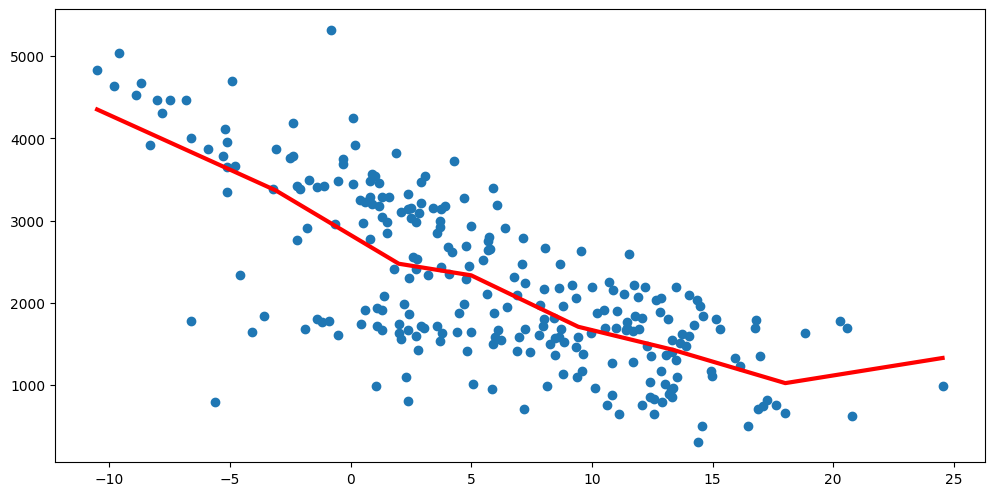

Wednesday


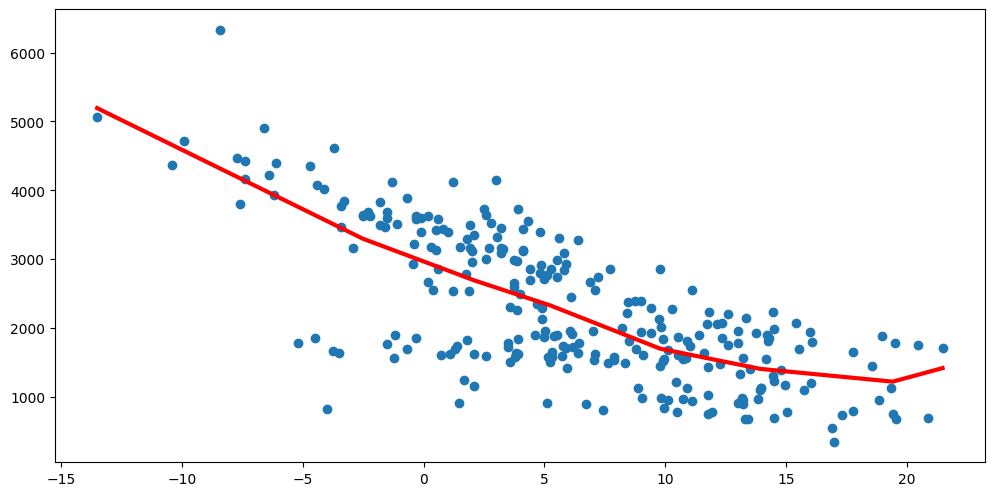

Thursday


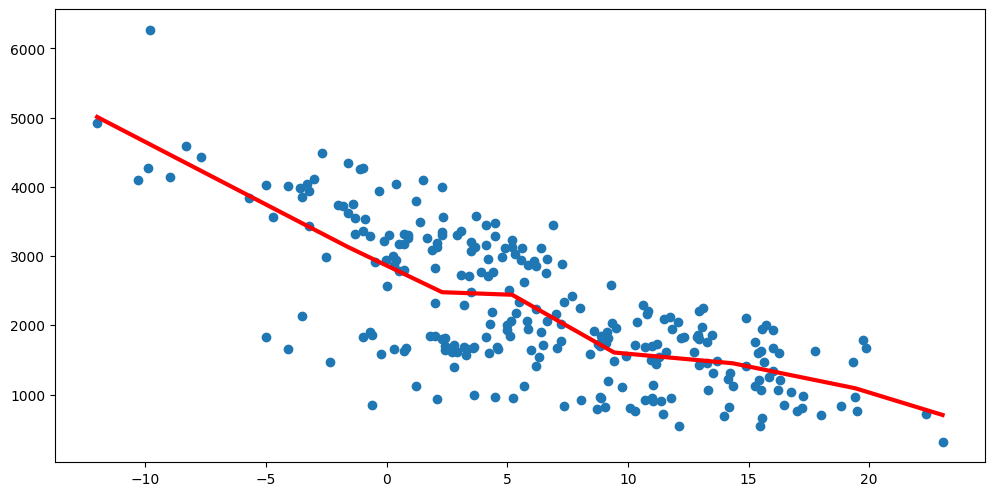

Friday


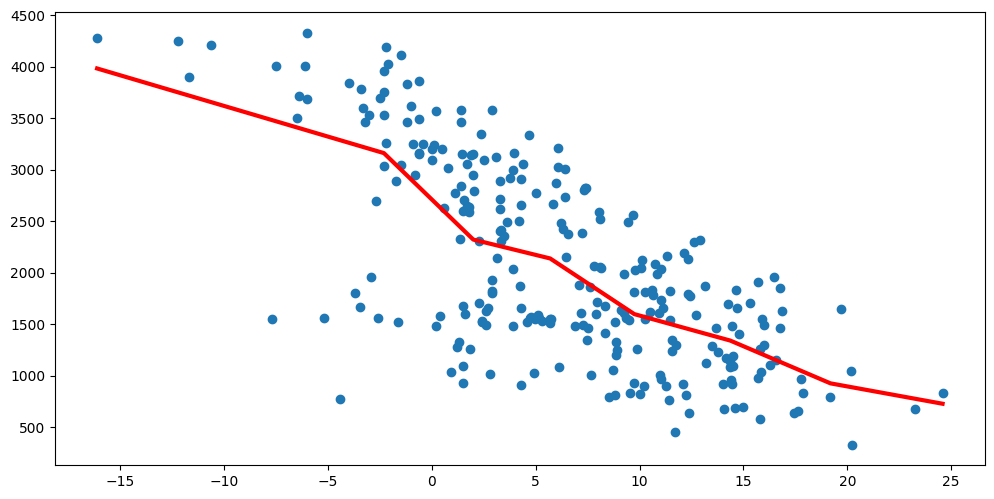

Saturday


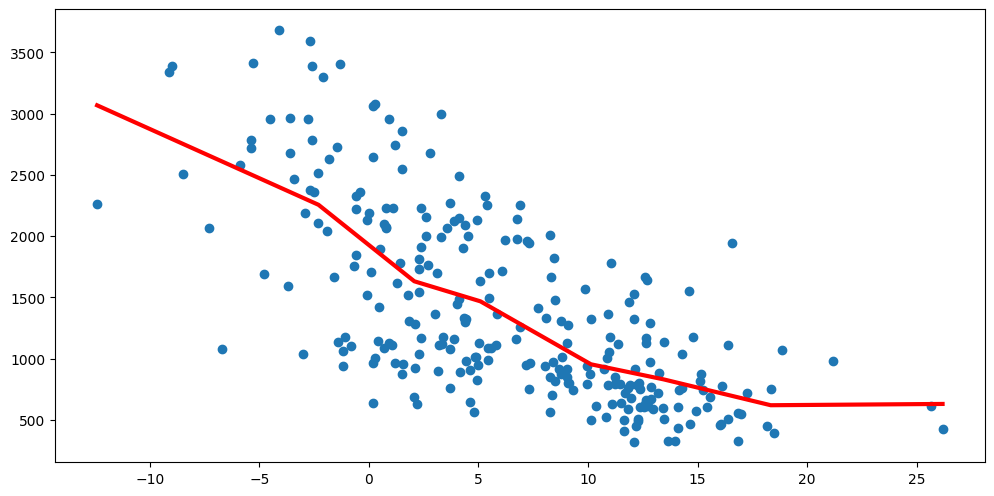

Sunday


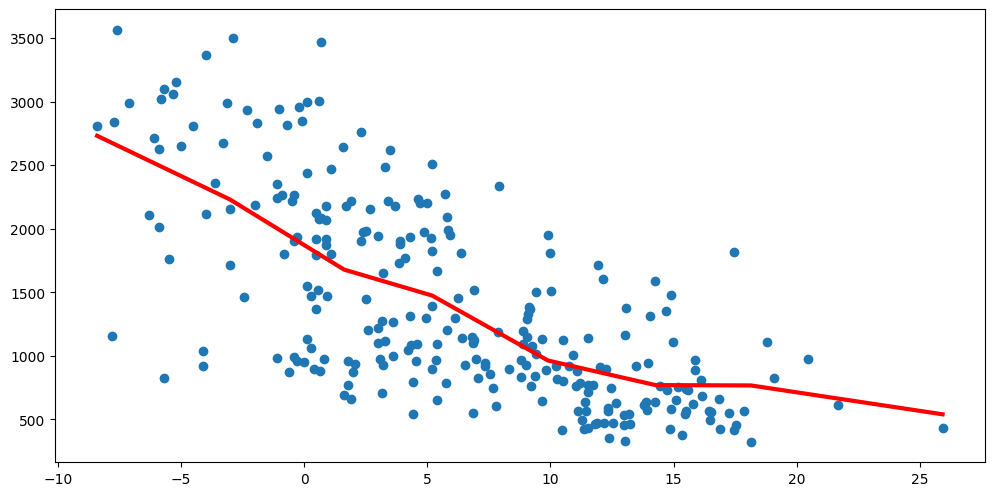

Trondheim Kommune - Ladesletta helse- og velferdssenter
Monday


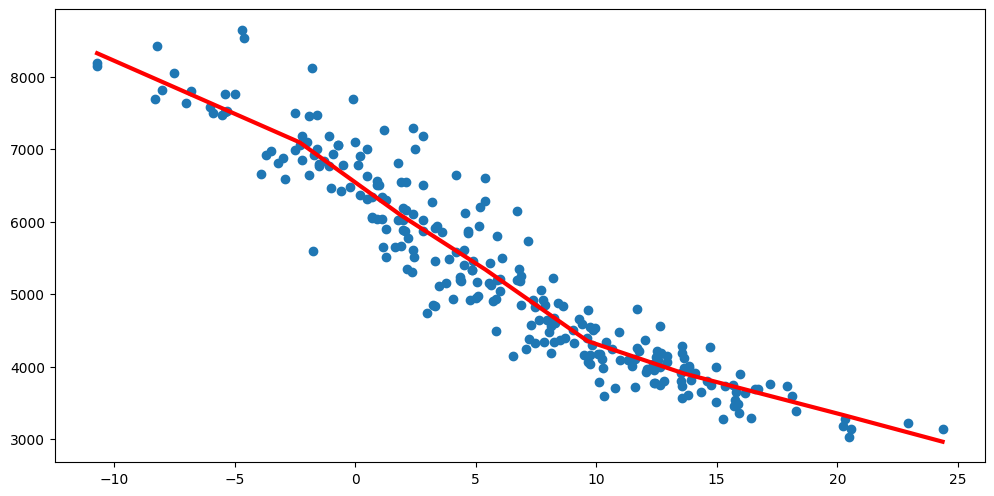

Tuesday


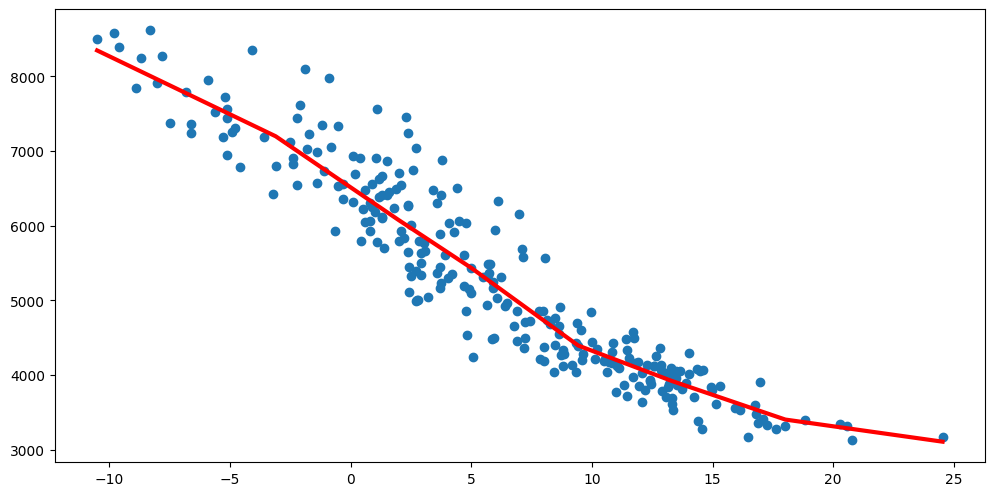

Wednesday


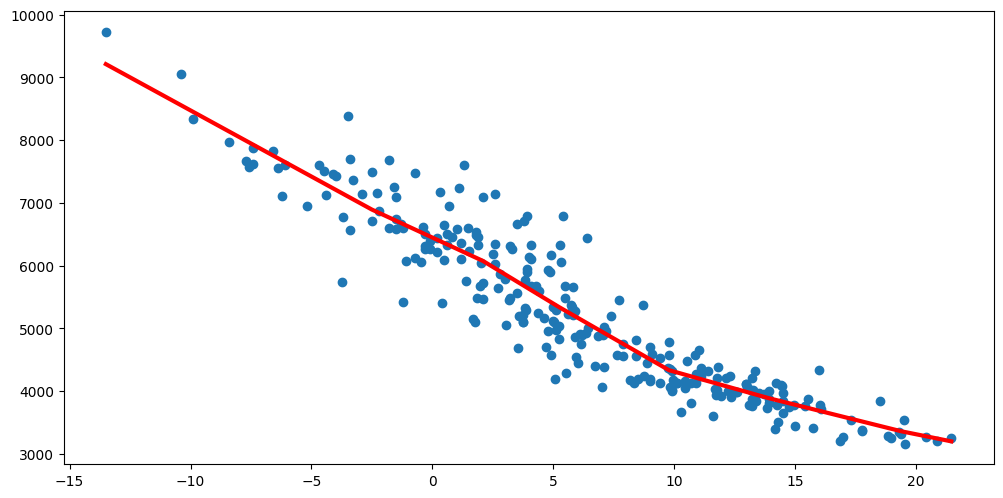

Thursday


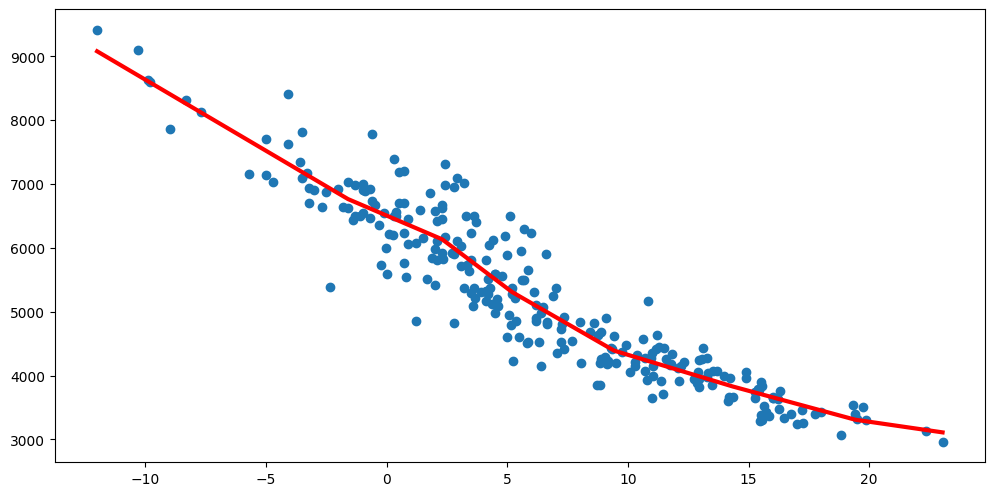

Friday


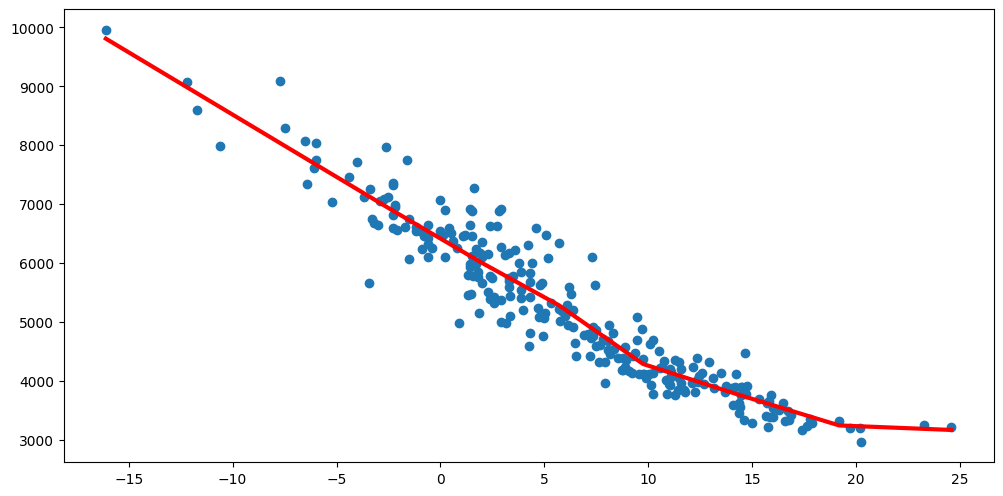

Saturday


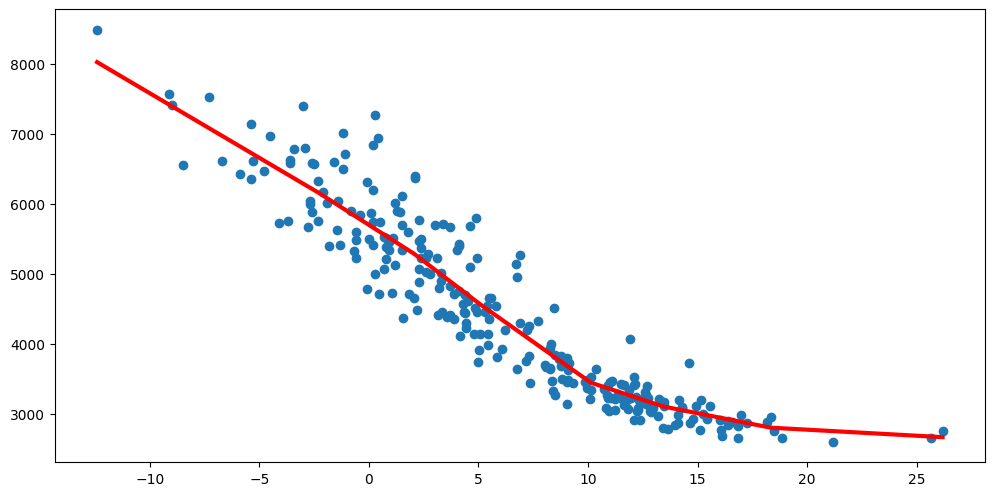

Sunday


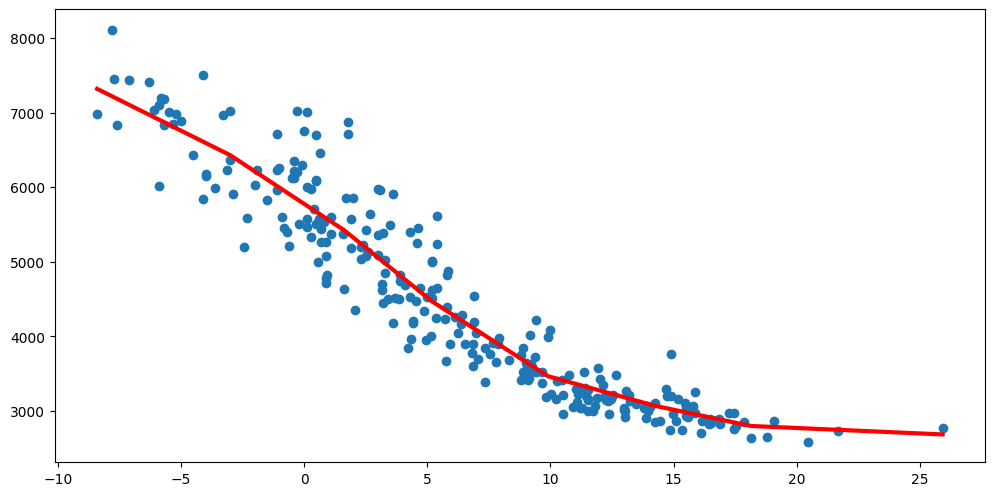

In [15]:
week_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

i = 0
et_curves_building_day_of_week = {}
for name, day_of_week_dfs in building_day_of_week_dfs.items():

    i += 1
    num_to_plot = 4
    if i < num_to_plot:
        print(name)

    et_curves_building_day_of_week[name] = {}

    for day_of_week, consumption_df in day_of_week_dfs.items():
        if i < num_to_plot:
            print(week_days[day_of_week])
        building_et_curve1 = generate_et_curve2(consumption_df['Totalt'], temp_voll_daily_mean, 50, i < num_to_plot)
        # building_et_curve2 = generate_et_curve3(consumption_df['Totalt'], temp_voll_daily_mean, 50, i < num_to_plot)
        et_curves_building_day_of_week[name][day_of_week] = building_et_curve1